<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/webscrape-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install selenium
# !apt-get update 
# !apt install chromium-chromedriver
# !pip install pandas_ta
# !pip install MarketProfile
import time
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

from selenium import webdriver

In [6]:
stocks = ['sic','nlg','igi','nil','nicl','sil','uic']

In [7]:
for stock in stocks:

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)

  url = f"https://www.sharesansar.com/company/{stock}"
  driver.get(url)
  driver.find_elements_by_xpath("//a[@href='#pricehistory']")[0].click()
  time.sleep(2)

  heading = []
  for i in range(0,9):
    h = driver.find_elements_by_xpath(f'//*[@id="companyprofilepricehistory_data"]/table/thead/tr/th[{i}]')
    for j in h:
      heading.append(j.text)


  data = []
  for p in range(3,12):
    for i in range(1,31):
      for j in range(0,9):
        d = driver.find_elements_by_xpath(f'//*[@id="companyprofilepricehistory_data"]/table/tbody/tr[{i}]/td[{j}]')
        for x in d:
          data.append(x.text)
    time.sleep(2)
    driver.find_elements_by_link_text(f"{p}")[0].click()
    # for chk in c
    
    time.sleep(2)
  driver.quit()

  df = pd.DataFrame(np.reshape(data,(int(len(data)/8),8)), columns=heading)

  df = df[['Date', 'Open', 'High', 'Low', 'LTP', 'Qty']]
  df['Date'] = df['Date'].apply(pd.to_datetime)
  df['Open'] = df['Open'].apply(pd.to_numeric)
  df['High'] = df['High'].apply(pd.to_numeric)
  df['Low'] = df['Low'].apply(pd.to_numeric)
  df['LTP'] = df['LTP'].apply(pd.to_numeric)
  import locale
  q = []
  locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
  for i in df['Qty']:
    q.append(locale.atoi(i))
  df['Volume'] = q

  df.sort_values(by = "Date", ascending = True, inplace = True)

  df.to_csv(f"{stock}.txt")

  data = None
  heading = None
  q = None

In [8]:
import pandas_ta as ta

In [79]:
for stock in stocks:
  df = pd.read_csv(f"/content/{stock}.txt")
  df['hma1'] = ta.wma(df['LTP'],30)
  df['hma2'] = ta.wma(df['LTP'].shift(-2),30)
  # df['LTP'].plot(figsize = (20,10))
  # ta.hma(df['LTP'],30).plot()
  # ta.hma(df['LTP'].shift(-2),30).plot()
  def signal(source):
    if source.hma1<source.hma2:
      return 1
    else:
      return -1
  df['Signal'] = df.apply(signal, axis=1)
  # source.set_index('Date',inplace = True)
  df['S'] = (df['Signal']-df['Signal'].shift(1))
  print("-"*30)
  initial_capital = 30000
  initial = 0
  buy = 0
  b = 0

  r = []
  for i in range(len(df)):
    if df['S'][i] == 2:
      buy_unit = initial_capital//df['LTP'][i]
      buy += buy_unit
      initial = initial_capital - (buy_unit * df['LTP'][i])
      initial_capital -= initial
      b += df['LTP'][i]
      d = (df.index[i])
      print(f"{stock} was bought on {df.index[i]} at {df['LTP'][i]}. Unit in stock {buy}. Remaining amount {initial}") 
    elif (df['S'][i] == -2) and (buy >0):
      sell = buy * df['LTP'][i] 
      buy = 0
      net = initial + (sell* df['LTP'][i])
      print(f"{stock} was sold on {df.index[i]} at {df['LTP'][i]}. Return {np.round(df['LTP'][i]/b,3)}")#. Time {df.index[i] - d}")
      r.append(df['LTP'][i]/b)
      b= 0
      d= 0

  print("*"*30)
  a = 10000
  c = 0
  for i in range(len(r)):
    b = a*(r[i]-1)*0.93
    a += b
    print(a)
  

------------------------------
sic was bought on 146 at 438.0. Unit in stock 68.0. Remaining amount 216.0
sic was sold on 207 at 730.0. Return 1.667
sic was bought on 227 at 672.0. Unit in stock 44.0. Remaining amount 216.0
sic was sold on 263 at 896.0. Return 1.333
******************************
16200.0
21222.0
------------------------------
nlg was bought on 50 at 740.0. Unit in stock 40.0. Remaining amount 400.0
nlg was sold on 51 at 762.0. Return 1.03
nlg was bought on 111 at 564.0. Unit in stock 52.0. Remaining amount 272.0
nlg was sold on 112 at 591.0. Return 1.048
nlg was bought on 143 at 520.0. Unit in stock 56.0. Remaining amount 208.0
nlg was sold on 188 at 869.0. Return 1.671
nlg was bought on 193 at 698.0. Unit in stock 41.0. Remaining amount 502.0
nlg was sold on 194 at 764.0. Return 1.095
nlg was bought on 225 at 626.0. Unit in stock 45.0. Remaining amount 448.0
nlg was sold on 258 at 717.0. Return 1.145
******************************
10276.486486486487
10734.008783783784

In [80]:
data = pd.read_csv("/content/nlg.txt")
data = data[['Date','Open','High','Low','LTP','Qty','Volume']]

In [81]:
ta.vp(data['LTP'],data['Volume'])


,low_LTP,mean_LTP,high_LTP,pos_Volume,neg_Volume,total_Volume
0,771.0,828.259259,882.0,53887.0,22205.0,76092.0
1,719.0,746.037037,766.0,23231.0,7890.0,31121.0
2,606.0,692.111111,730.0,18230.0,6783.0,25013.0
3,548.0,587.148148,642.0,50938.0,6763.0,57701.0
4,505.0,546.703704,591.0,32300.0,6170.0,38470.0
5,495.0,563.333333,614.0,36748.0,21695.0,58443.0
6,605.0,751.037037,881.0,124271.0,112783.0,237054.0
7,545.0,680.111111,845.0,160645.0,108298.0,268943.0
8,518.0,636.629630,788.0,84275.0,42349.0,126624.0
9,686.0,719.296296,770.0,99209.0,79272.0,178481.0


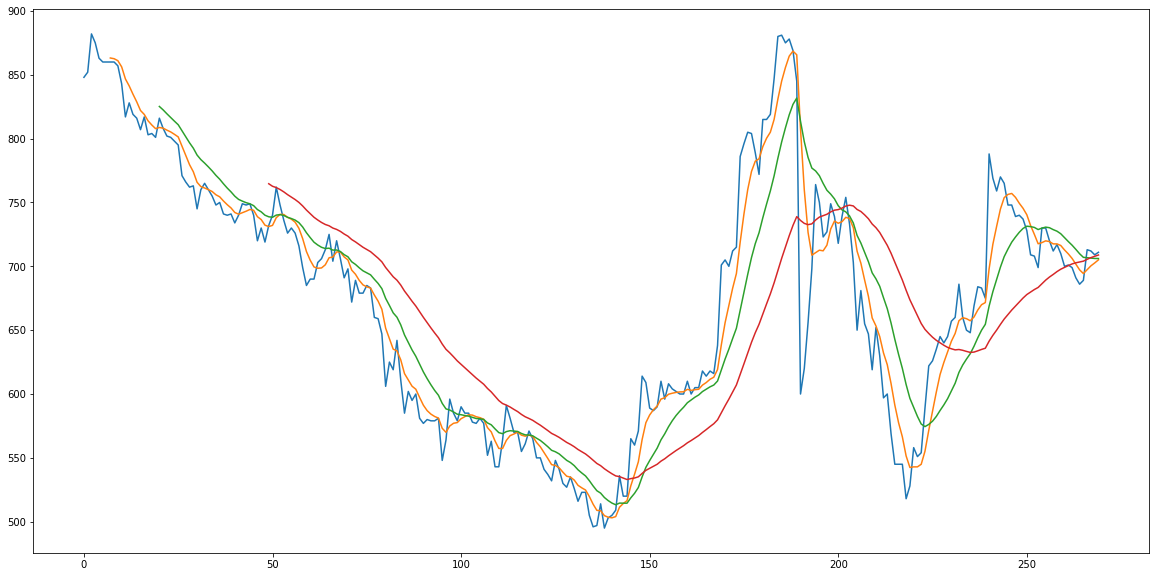

In [117]:
import matplotlib.pyplot as plt

data['hma1'] = ta.wma(data['LTP'],8)
data['hma2'] = ta.wma(data['LTP'],21)
data['hma3'] = ta.wma(data['LTP'],50)
plt.figure(figsize = (20,10))
plt.plot(data['LTP'])
plt.plot(data['hma1'])
plt.plot(data['hma2'])
plt.plot(data['hma3'])
# plt.hlines(824,0,200)
# plt.hlines(778,0,200)
# plt.hlines(914,0,200)

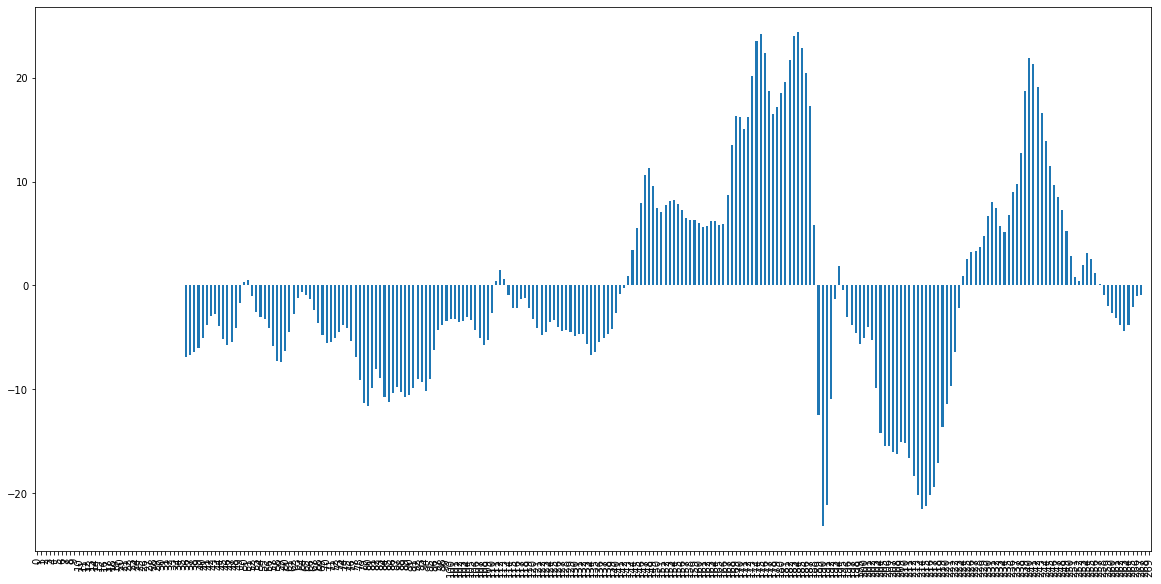

In [103]:
(data['hma2']-data['hma1']).plot(kind ='bar', figsize = (20,10))

Calculating Alpha and Beta

In [61]:
import statsmodels.api as sm
from statsmodels import regression 

def linreg(x,y):
  x = sm.add_constant(x)
  model = regression.linear_model.OLS(y,x).fit()
  x = x[:,1]
  return model.params[0],model.params[1]

In [66]:
for stock in stocks:
  index = pd.read_csv('/content/non_index', sep = "\t")
  index['Date'] = index["Date"].apply(pd.to_datetime)
  index['IV'] = A2
  
  data = pd.read_csv(f"/content/{stock}.txt")
  data['Date'] = data['Date'].apply(pd.to_datetime)
  r = pd.merge(data,
             index,
             how = 'inner')
  r['IV'] = r['IV'].apply(pd.to_numeric)
  alpha,beta = linreg(r['LTP'].pct_change()[1:].values, r['IV'].pct_change()[1:].values)
  print(f"{stock}: {alpha} and  {beta*100}")
  



sic: 0.0018066308679391453 and  41.3548192978193
nlg: 0.0015567298468637822 and  50.61196270566869
igi: 0.0007668503160571095 and  64.51669313575454
nil: 6.86411106534388e-05 and  68.16070653862954
nicl: 0.000352383510915034 and  66.19129956264655
sil: 0.0006432338477654223 and  67.95719798569978
uic: 0.0019488071683816052 and  29.921247553039464


In [67]:
index = pd.read_csv('/content/non_index', sep = "\t")
index['Date'] = index["Date"].apply(pd.to_datetime)
index['IV'] = A2

In [70]:
t = index.copy()
t = t[['date','IV']]

In [72]:
t['IV'] = t['IV'].apply(pd.to_numeric)

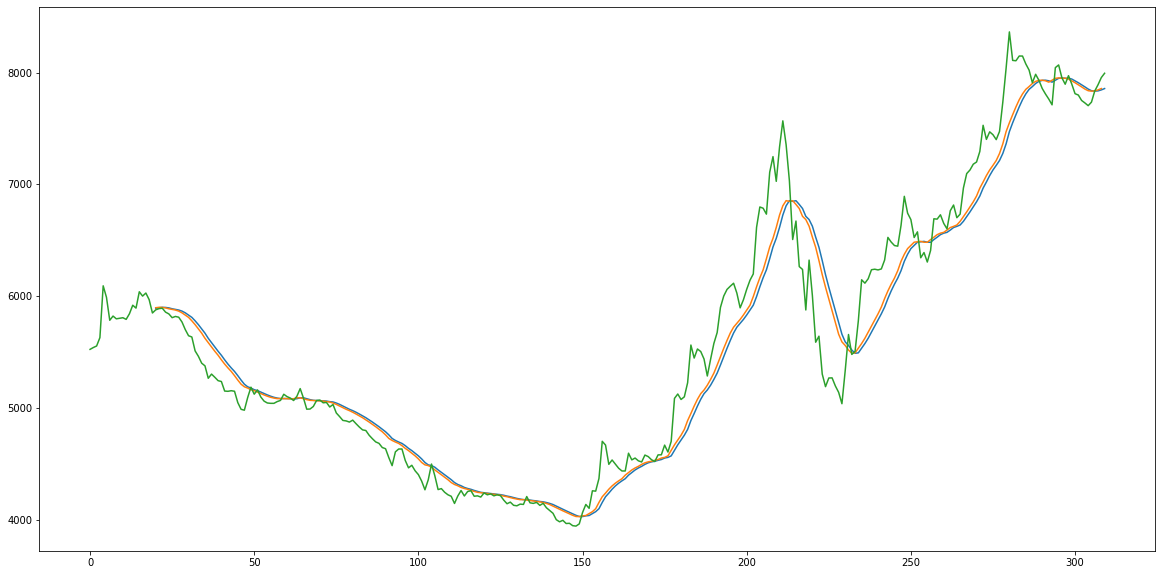

In [77]:
ta.wma(t['IV'],21).plot(figsize = (20,10))
ta.wma(t['IV'].shift(-1), 21).plot(figsize = (20,10))
t['IV'].plot()